# Training and Evaluating Models with the Data-Driven Library

This notebook provides an overview of the tools built in the DDM for extracting predictions from your trained DDM and for evauating the performance of the DDM.

---

We utilize `hydra` to save the configuration of our datasets and our models. The default configuration is in the `conf/config.yaml` directory:

```YAML
defaults:
  - data: house_energy.yaml
  - model: xgboost.yaml
  - simulator: house_energy_simulator.yaml
```

Note that the configuration file points to three additional configuration files for each component: the data, the model, and the simulator.

While the configuration file already has default values specified you can override any element of the configuration file using the `overrides` option. For example, we can override the data configuration to instead use the `yaml` file specified in `data/cartpole-100K-cts.csv.yaml` and the model configuration to use the `yaml` file specified in `model/SVR.yaml`.


In [1]:
cd ..

/Users/jill/bonsai/datadrivenmodel


In [2]:
from hydra.experimental import initialize, compose
from omegaconf import DictConfig, ListConfig, OmegaConf
from model_loader import available_models
import logging
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from rich.logging import RichHandler
import copy
from assessment_metrics_loader import available_metrics

logging.basicConfig(
    level=logging.INFO,
    format="%(message)s",
    datefmt="[%X]",
    handlers=[RichHandler()]
)
logger = logging.getLogger("ddm_notebook")
logger.setLevel(logging.INFO)

In [3]:
initialize(config_path="../conf", job_name="model_train_validate")
cfg = compose(config_name="config", overrides=["data=house-energy", "model=xgboost"])

/Users/jill/opt/anaconda3/envs/ddm/lib/python3.8/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive model/xgboost.yaml in file:///Users/jill/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/Users/jill/opt/anaconda3/envs/ddm/lib/python3.8/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive data/house-energy.yaml in file:///Users/jill/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/Users/jill/opt/anaconda3/envs/ddm/lib/python3.8/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive simulator/house_energy_simparam.yaml in file:///Users/jill/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warning

## 1. Importing the Dataset

In [4]:
# Extract features from yaml file
input_cols = cfg['data']['inputs']
output_cols = cfg['data']['outputs']
augmented_cols = cfg['data']['augmented_cols']
dataset_path = cfg['data']['path']
iteration_order = cfg['data']['iteration_order']
episode_col = cfg['data']['episode_col']
iteration_col = cfg['data']['iteration_col']
max_rows = cfg['data']['max_rows']
diff_state = cfg['data']['diff_state']
test_perc = cfg['data']['test_perc']

In [5]:
print("DATA STRUCTURE SELECTED:")
print(" - input_cols:", input_cols)
print(" - augmented_cols:", augmented_cols)
print(" - output_cols:", output_cols)

##  2. Model Definition

The `available_models` dictionary provides wrappers for the available models in this repository. We utilize `cfg["model"]` to load and build the model specified in the `model.yaml` file.

### Hyperparameters

Every model has its own hyperparameters, specified through the `cfg["model"]["build_params"]` dictionary, which can be modified directly in the dictionary below or through the `hydra` overrides.

In [6]:
cfg["model"]["build_params"]

{'model_type': 'xgboost', 'fit_separate': False, 'halt_model': False, 'n_estimators': 100, 'objective': 'reg:squarederror', 'learning_rate': 0.3, 'scale_data': True, 'max_depth': 6}

## 3. Train the Model

In [7]:
def train_models(config=cfg):

    logger.info(f'Model type: {available_models[config["model"]["name"]]}')
    Model = available_models[config["model"]["name"]]
    model = Model()
    logger.info(f"Building model with parameters: {config}")
    model.build_model(
        **config["model"]["build_params"]
    )
    logger.info(f"Loading data from {dataset_path}")
    X, y = model.load_csv(
        input_cols=input_cols,
        output_cols=output_cols,
        augm_cols=list(augmented_cols),
        dataset_path=dataset_path,
        iteration_order=iteration_order,
        episode_col=episode_col,
        iteration_col=iteration_col,
        max_rows=max_rows,
    )
    global X_train, y_train, X_test, y_test
    train_id_end = int(np.floor(X.shape[0] * (1 - test_perc)))
    X_train, y_train = (X[:train_id_end,],y[:train_id_end,],)
    X_test, y_test = (X[train_id_end:,],y[train_id_end:,],)
    
    logger.info(f"Fitting model...")
    model.fit(X_train, y_train)
    logger.info(f"Model trained!")
    y_pred = model.predict(X_test)
    r2_score = available_metrics["r2_score"]
    logger.info(f"R^2 score is {r2_score(y_test,y_pred)} for the test set.")

    return model

In [8]:
model = train_models(cfg)

/Users/jill/opt/anaconda3/envs/ddm/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


/Users/jill/opt/anaconda3/envs/ddm/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Save Model

In [12]:
model.save_model(filename=cfg["model"]["saver"]["filename"])

### Data Structure of Saved model

In [13]:
logger.info(f"Input_cols:  {model.features}")
logger.info(f"Output_cols: {model.labels}")

## 4. Model Evaluations

We provide three methods for evaluating the errors of our trained models:

1. Model predictive error: using a specified metric (such as R^2 or RMSE) and a test set, we evaluate the metric on the test set.
2. Visualization of per-iteration predictions on a test set
3. Visualization of sequential predictions on a test set

### 4.1. Overall Prediction Score

In [18]:
# Select your scoring method: r2_score, root_mean_squared_error, or mean_squared_error
scoring_method = available_metrics["r2_score"]

In [32]:
# Evaluate the model using the test set
per_iteration_eval_table = model.evaluate(X_test, y_test, scoring_method, marginal=True)

In [33]:
if (per_iteration_eval_table["score"] < 0.7).any():
    logger.warn("Per-iteration assessment R^2 is low. Please review your model.")

per_iteration_eval_table

,var,score
0,Tin,0.999842


### 4.2. Per-Iteration Predictions

In [21]:
# Use the the input columns at time t to predict the output column(s) at time t+1
y_preds = model.predict(X_test)

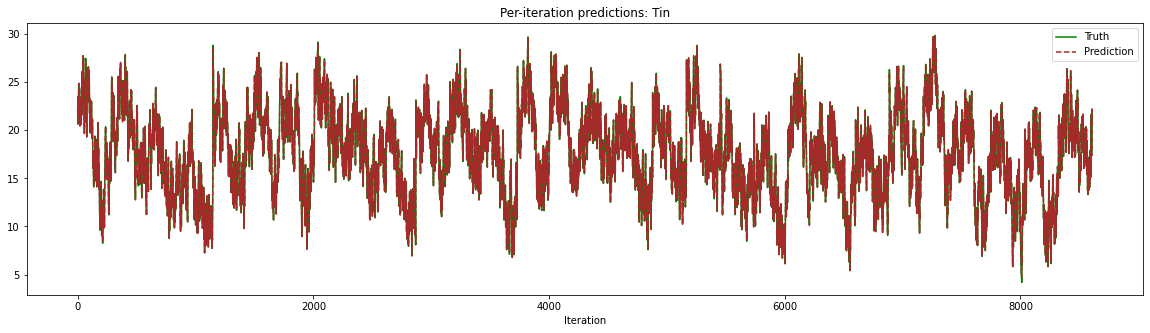

In [23]:
# Plot all prediction results
label_count = np.shape(y_preds)[1]
for i in range(label_count):
    fig = plt.figure(figsize=(20,5))
    plt.plot(y_test[:,i], "green")
    plt.plot(y_preds[:,i], "brown", linestyle='--')
    plt.title(f"Per-iteration predictions: {model.labels[i]}")
    plt.xlabel("Iteration")
    plt.legend(["Truth", "Prediction"])

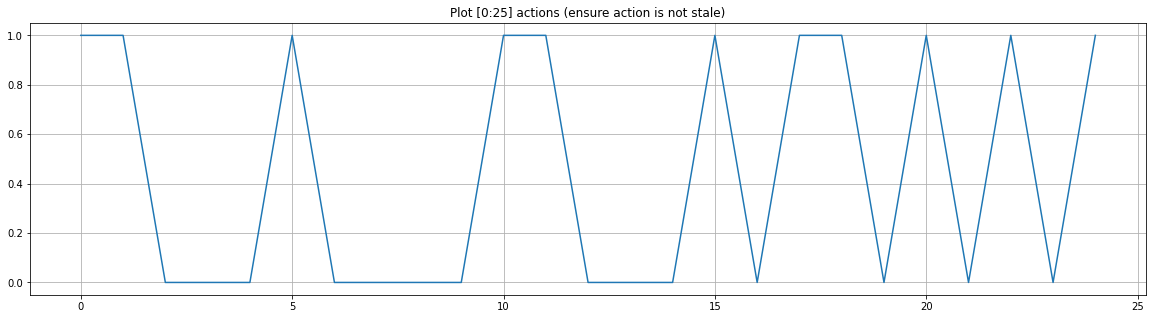

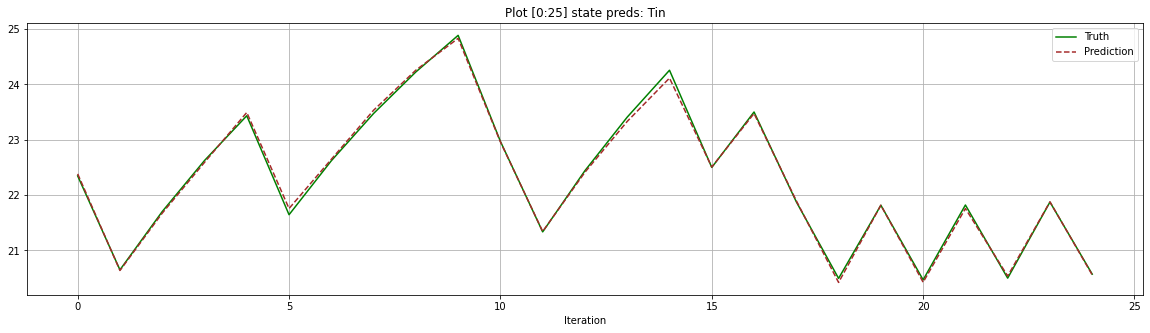

In [31]:
# Zoom in on a specific section
iteration_start = 0
iteration_stop = 25

# Define which input column is the action
action_col = "hvacON"

# Plot action changes -- zoomed in
fig = plt.figure(figsize=(20,5))
action_idx = model.features.index(action_col)
plt.title(f"Plot [{iteration_start}:{iteration_stop}] actions (ensure action is not stale)")
plt.plot(X_test[iteration_start:iteration_stop,action_idx])
plt.grid()
    
# Plot output changes -- zoomed in
fig = plt.figure(figsize=(20,5))
label_idx = 0
plt.title(f"Plot [{iteration_start}:{iteration_stop}] state preds: {model.labels[label_idx]}")
plt.plot(y_test[iteration_start:iteration_stop,label_idx], "green")
plt.plot(y_preds[iteration_start:iteration_stop,label_idx], "brown", linestyle='--')
plt.xlabel("Iteration")
plt.legend(["Truth", "Prediction"])
plt.grid()

### 4.3. Sequential Predictions

In [ ]:
# number of iterations to predict sequentially
# - taking the value defined above by default -
it_per_episode = it_per_episode

In [ ]:
preds_sequentially = model.predict_sequentially(X, episode_ids=it_per_episode)

In [ ]:
# Plot results graphs
label_count = np.shape(preds_sequentially)[1]
fig,axs = plt.subplots(3,2,)
for i in range(label_count):
    axs[i//2,i%2].set_title(f"Sequential predictions: {model.labels[i]}")
    axs[i//2,i%2].plot(y[:,0], "green")
    axs[i//2,i%2].plot(preds_sequentially[:,i], "brown")
    
# select section to zoom in (for both action & episode visualization)
sample_from = 0
sample_to = 100

# Plot action changes
action_idx = model.features.index(action_feat)
axs[(i+1)//2,(i+1)%2].set_title(f"Plot [{sample_from}:{sample_to}] actions (ensure action is not stale)")
axs[(i+1)//2,(i+1)%2].plot(X[sample_from:sample_to,action_idx])
    
# Plot prediction graph -- with zoom on 100 iterations
action_idx = model.features.index(action_feat)
feat_idx = 0
axs[(i+2)//2,(i+2)%2].set_title(f"Plot [{sample_from}:{sample_to}] state preds: {model.labels[feat_idx]}")
axs[(i+2)//2,(i+2)%2].plot(y[sample_from:sample_to,feat_idx], "green")
axs[(i+2)//2,(i+2)%2].plot(preds_sequentially[sample_from:sample_to,feat_idx], "brown")

## 5. Comparing Model Evaluations

If you want to compare various models, you can use the following section to save them in between runs.

1. Select appropriate "model_name" tag, and run this section
2. Change config through "config.yaml" (located at 'conf' folder)
3. Rerun from Model Build, until this section
4. Define a new value for "model_name" tag, and run this section again

In [ ]:
# select model name, and feats to extract
model_name = "xgb"

In [ ]:
# per-iteration & sequential scores
model_per_it_scores = copy.deepcopy(per_iteration_eval_table)
model_sequential_scores = copy.deepcopy(sequential_eval_table)

In [ ]:
# initialize models dictionary if it doesn't exist already
if 'models_dict' not in locals():
    models_dict = dict()

# append tables to model using selected model name as key
models_dict[model_name] = (model_per_it_scores, model_sequential_scores)

# redefine column names if needed
for model_name, score_tables in models_dict.items():
    for score_table in score_tables:
        for col_name in score_table.columns:
            if "score" in col_name and model_name not in col_name:
                score_table.rename(columns = {col_name:model_name+"_"+col_name}, inplace = True)

# concatenate across all models
all_scores = None
for model_name, score_tables in models_dict.items():
    for score_table in score_tables:
        if all_scores is None:
            all_scores = score_table
        else:
            all_scores = all_scores.merge(score_table,how='outer')

all_scores